In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import LabelEncoder
import torch
import matplotlib as plt


dtypes = {
  'Region':                  object,
  'District':                object,
  'CDI':                     float,
  'Month':                   object,
  'Year':                    int,
  'NDVI':                    float,
  'Rainfall':                float,
  'Water Price':             float,
  'Conflict Fatalities':     float,
  'Conflict Incidents':      float,
  'Cholera Deaths':          float,
  'Cholera Cases':           float,
  'Malaria':                 float,
  'Measles':                 float,
  'Cost Min Basket':         float,
  'Goat Price':              float,
  'Goat to Cereal':          float,
  'Maize Price':             float,
  'Rice Price':              float,
  'Sorghum Price':           float,
  'Wage Price':              float,
  'Wage to Cereal':          float,
  'Arrivals':                int,
  'Departures':              int,
}
df = pd.read_csv('data/combined_data.csv')
print(f'90th percentile: {df["Arrivals"].quantile(q=0.90)}')
print(df["Arrivals"].describe())


def prepare_data(df):
  """
  Prepare the data for training, deal with NaNs. I think we also need to drop the 2014 years?
  """

  # remove commas in numeric columns
  for feature in df.columns:
    df[feature] = df[feature].apply(lambda x: x.replace(',', '') if isinstance(x, str) else x)

  # force numeric 
  numeric_cols = ['Cost Min Basket', 'Goat Price', 'Goat to Cereal', 'Maize Price', 'Rice Price', 'Sorghum Price', 'Wage Price', 'Arrivals']
  df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

  # make categorical columns
  df = df.astype({"Region": 'category', "District": 'category', "Month": 'category'})

  # drop columns that arent useful
  keep_cols = ['Arrivals', 'Region', 'District', 'Month', 'Rainfall', 'Conflict Fatalities', 'Conflict Incidents', 'Water Price', 'Goat Price']
  df = df[keep_cols]
  df = df.dropna()

  # print(f'arrivals described: \n {df["Arrivals"].describe()} \n ')
  # print(f'10 largest arrivals: \n {df.nlargest(10, "Arrivals")["Arrivals"]}')

  return df


df = prepare_data(df)

/var/folders/rt/d3s5hnhn7sb9m39n0ky1cyrc0000gn/T/ipykernel_69161/3270117141.py:44: DtypeWarning: Columns (17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/combined_data.csv')


90th percentile: 1677.0
count    191416.000000
mean       1226.451807
std        5534.244627
min           1.000000
25%          49.000000
50%         194.000000
75%         614.000000
max      259678.000000
Name: Arrivals, dtype: float64


In [14]:
# encode dataframe
# encoded_df = pd.get_dummies(df, columns=['Region', 'District', 'Month'], drop_first=True)

# encode categorical columns in dataframe
encoder = LabelEncoder()
encoder.fit(df['Region'])
df['Region'] = encoder.transform(df['Region'])
encoder.fit(df['District'])
df['District'] = encoder.transform(df['District'])
encoder.fit(df['Month'])
df['Month'] = encoder.transform(df['Month'])
train, test = train_test_split(df, test_size=0.2)

train, test = train_test_split(df, test_size=0.2)

# create train and test split
X_train = train.drop(['Arrivals'], axis=1)
y_train = train[['Arrivals']]

X_test = test.drop(['Arrivals'], axis=1)
y_test = test[['Arrivals']]

In [3]:
def classification_accuracy(y_true, y_pred):
    """
    Return the classification accuracy of the predicted labels.
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Arrays must be of equal length")

    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [15]:
# fit the model
LR = LinearRegression()
LR.fit(X_train, y_train)

# evaluate model based on bins
true_bins = pd.cut(y_test['Arrivals'], bins=[0, 1000, 5000, float('inf')], labels=[1, 2, 3], right=False)
preds_bin = np.digitize(LR.predict(X_test), bins=[0, 1000, 5000, float('inf')], right=False).flatten()

print(f'score: {LR.score(X_test, y_test)}')
print(f'rmse: {math.sqrt(mean_squared_error(LR.predict(X_test), y_test))}')
print(f'classification accuracy: {classification_accuracy(true_bins, preds_bin)}')

score: 0.017764458355284063
rmse: 6004.753515497336
classification accuracy: 0.4253840809078978


In [6]:
# fit the model
SVR = SVR()
SVR.fit(X_train, y_train)

# evaluate model based on bins
true_bins = pd.cut(y_test['Arrivals'], bins=[0, 1000, 5000, float('inf')], labels=[1, 2, 3], right=False)
preds_bin = np.digitize(SVR.predict(X_test), bins=[0, 1000, 5000, float('inf')], right=False).flatten()

print(f'score: {SVR.score(X_test, y_test)}')
print(f'rmse: {math.sqrt(mean_squared_error(SVR.predict(X_test), y_test))}')
print(f'classification accuracy: {classification_accuracy(true_bins, preds_bin)}')

/Users/jakegilbert/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# fit the model
DT = DecisionTreeRegressor(max_depth=11)
DT.fit(X_train, y_train)

# evaluate model based on bins
true_bins = pd.cut(y_test['Arrivals'], bins=[0, 1000, 5000, float('inf')], labels=[1, 2, 3], right=False)
preds_bin = np.digitize(DT.predict(X_test), bins=[0, 1000, 5000, float('inf')], right=False).flatten()

print(f'score: {DT.score(X_test, y_test)}')
print(f'rmse: {math.sqrt(mean_squared_error(DT.predict(X_test), y_test))}')
print(f'classification accuracy: {classification_accuracy(true_bins, preds_bin)}')

score: 0.6045116727452025
rmse: 3846.5967131140856
classification accuracy: 0.9719756041071567


In [6]:
# fit the model
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

# evaluate model based on bins
true_bins = pd.cut(y_test['Arrivals'], bins=[0, 1000, 5000, float('inf')], labels=[1, 2, 3], right=False)
preds_bin = np.digitize(RF.predict(X_test), bins=[0, 1000, 5000, float('inf')], right=False).flatten()

print(f'score: {RF.score(X_test, y_test)}')
print(f'rmse: {math.sqrt(mean_squared_error(RF.predict(X_test), y_test))}')
print(f'classification accuracy: {classification_accuracy(true_bins, preds_bin)}')

/var/folders/rt/d3s5hnhn7sb9m39n0ky1cyrc0000gn/T/ipykernel_69161/2206423192.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


score: 0.8726278694200728
rmse: 2182.966283202876
classification accuracy: 0.9902725237396742


In [53]:
preds = RF.predict((X_test))
y_true = y_test.values.flatten()
diffs = preds - y_true

print(f'percent of perfect predictions: {(np.count_nonzero(diffs == 0) / len(diffs))}')

percent of perfect predictions: 0.9793870145912144


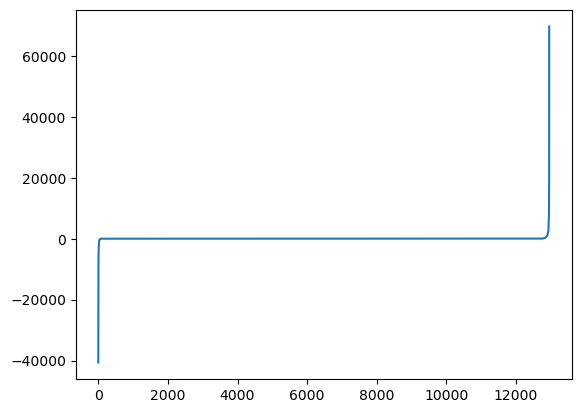

In [65]:
# plot of differences
plt.plot(np.sort(diffs))


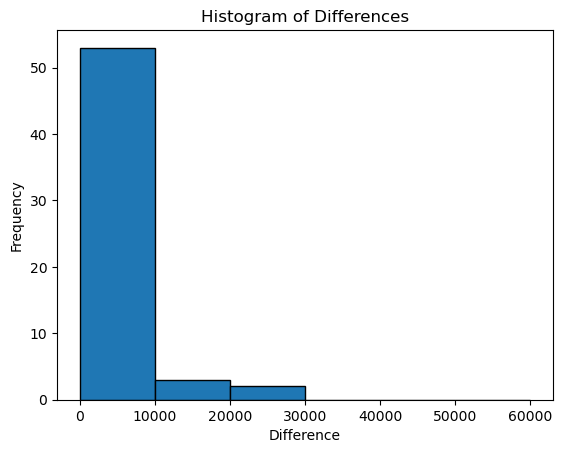

In [62]:
# plot only the differences greater than 1000
preds = RF.predict((X_test))

bins = np.arange(0, max(diffs), 10000)
plt.hist(diffs[diffs > 1000], bins=bins, edgecolor='black')

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')

plt.show()

In [9]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, input_dim):
        super().__init__()

        self.loss_fn = torch.nn.L1Loss()

        self.pipeline = torch.nn.Sequential(
                torch.nn.Linear(input_dim, 512),
                torch.nn.Sigmoid(),
                torch.nn.Linear(512, 128),
                torch.nn.Sigmoid(),
                torch.nn.Linear(128, 32),
                torch.nn.Sigmoid(),
                torch.nn.Linear(32, 1)
        )


    def forward(self, x):
        return self.pipeline(x)
    

    def train(self, X, y, learning_rate, num_epochs):

        for epoch in range(num_epochs):
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

            pred = self.forward(torch.tensor(X.values, dtype=torch.float32))

            # evaluate loss on prediction
            loss = self.loss_fn(pred, torch.tensor(y.values, dtype=torch.float32))

            # compute gradient
            loss.backward()

            # take an optimization step
            optimizer.step()


    def evaluate(self, X, y):
        true_bins = pd.cut(y['Arrivals'], bins=[0, 1000, 5000, float('inf')], labels=[1, 2, 3], right=False)
        preds = self.forward(torch.Tensor(X.values)).detach()
        preds_bins = np.digitize(preds, bins=[0, 1000, 5000, float('inf')], right=False).flatten()

        print(f'rmse: {math.sqrt(mean_squared_error(preds, y))}')
        print(f'classification accuracy: {classification_accuracy(true_bins, preds_bins)}')


NN = NeuralNetwork(len(list(X_train.columns)))

In [10]:
learning_rate = 0.01
num_epochs = 10
NN.train(X_train, y_train, learning_rate, num_epochs)

In [11]:
NN.evaluate(X_test, y_test)

rmse: 6180.975084770626
classification accuracy: 0.8090017756504285
